## Limit order book

author: Jian Wang

time: 2016-02-05

# Model training and fitting

## 1.Model prepare

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 26 00:03:47 2016

@author: jianwang
"""

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
import time
import matplotlib.pyplot as plt

#Set default parameters
ticker_list=["AAPL","AMZN","GOOG","INTC","MSFT"]
start_ind=10*3600
end_ind=15.5*3600
data_order_list=[]
data_mess_list=[]
time_index_list=[]
path_save='/media/jianwang/Study/Research/order_book/'
path_load="/media/jianwang/Study/Research/order_book/"

## set random seed to produce the same results

np.random.seed(987612345)

#read the stock ticker
#totally 5 dataset

for i in range(len(ticker_list)):
    #get the path for the csv files
    # name_order is for the order book and name_mess for the message book
    name_order='_2012-06-21_34200000_57600000_orderbook_10.csv'
    name_mess='_2012-06-21_34200000_57600000_message_10.csv'
    # calculate the cputime for reading the data
    t=time.time()
    # header =-1 means that the first line is not the header, otherwise, the first line will be header
    # data_order is for order book and data mess is for message book
    data_order_list.append(np.array(pd.read_csv(path_load+ticker_list[i]+name_order,header=-1),dtype="float64"))
    data_mess_list.append(np.array(pd.read_csv(path_load+ticker_list[i]+name_mess,header=-1),dtype="float64"))
    print("Time for importing the "+ticker_list[i]+" data is:",time.time()-t)
    print("The shape of the order data is: ",data_order_list[i].shape, " of message data is: ", data_mess_list[i].shape)
    # get the time index
    time_index_list.append(data_mess＿list[i][:,0])


#print the sample of data
print("Check the original data:")

for i in range(len(ticker_list)):
    print()
    print("The first five sampe of "+ticker_list[i]+" is: ",data_order_list[i][:3])

    # -*- coding: utf-8 -*-

# # save the feature array
# ##get the original order,message and time index data, header =-1 means that did not
# ##read the first column as the name
#%%
# # use a loop to read data
# for ticker_ind in range(len(ticker_list)):
#     data_order=data_order_list[ticker_ind]
#     data_mess=data_mess_list[ticker_ind]
#     time_index=data_mess[:,0]
#     # obtain the reduced order message and time_index dataset, half an hour after the
#     # 9:30 and half an hour before 16:00
#     # data_reduced is used to install the data from 10 to 15:30, take half hour for auction
#     data_order_reduced=data_order[(time_index>= start_ind) & (time_index<= end_ind)]
#     data_mess_reduced=data_mess[(time_index>= start_ind) & (time_index<= end_ind)]
#     time_index_reduced=time_index[(time_index>= start_ind) & (time_index<= end_ind)]

#     test_lower=0
#     # test up is the up index of the original data to construct the test data
#     test_upper=len(data_order_reduced)
#     # data_test is the subset of data_reduced from the lower index to upper index
#     data_order_test=data_order_reduced[test_lower:test_upper,:]
#     data_mess_test=data_mess_reduced[test_lower:test_upper,:]
#     t=time.time()
#     feature_array=get_features (data_order, data_mess,data_order_test,data_mess_test)
#     np.savetxt(path_save+ticker_list[ticker_ind]+'_feature_array.txt',feature_array,delimiter=' ')
#     print ("Time for building "+ticker_list[ticker_ind]+" is:",time.time()-t)


# load the feature
#%%
import time
t=time.time()
feature_array_list=[]
for ticker_ind in range(len(ticker_list)):
    feature_array_list.append(np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_feature_array.txt',\
                                                   sep=' ',header=-1)))
print(time.time()-t)

# this function used to build the y
# ask_low as 1 bad high as -1 and no arbitrage as 0
# option=1 return ask low, option =2 return bid high, option =3 return no arbi, option =4 return total(ask_low=1,
# bid_high =-1 and no arbi =0)
#%%
def build_y(ask_low,bid_high,no_arbi,option):
    if (option==1):
        return ask_low
    elif option==2:
        return bid_high
    elif option==3:
        return no_arbi
    elif option==4:
        return ask_low-bid_high
    else:
        print("option should be 1,2,3,4")

## save y data
#%%
#time_ind=1
#option_ind=1
#for ticker_ind in range(len(ticker_list)):
#    response=build_y(ask_low_time_list[ticker_ind][time_ind],bid_high_time_list[ticker_ind][time_ind],\
#                                 no_arbi_time_list[ticker_ind][time_ind],option=option_ind)
#    np.savetxt(path_save+ticker_list[ticker_ind]+'_response.txt',response)



## load y data
#%%
response_list=[]
for ticker_ind in range(len(ticker_list)):
    response_list.append((np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_response.txt',header=-1))))


## print the shape of the response
## note it is the total response
#%%
print("The shape of the total response is:\n")

for ticker_ind in range(len(ticker_list)):
    print(response_list[ticker_ind].shape)

# need to get the response from 10 to 15:30
# the shape of the response and the feature array should be equal
response_reduced_list=[]
for ticker_ind in range(len(ticker_list)):
    first_ind = np.where(time_index_list[ticker_ind]>=start_ind)[0][0]
    last_ind=np.where(time_index_list[ticker_ind]<=end_ind)[0][-1]
    response_reduced_list.append(response_list[ticker_ind][first_ind:last_ind+1])

print("The shape of the reduced response is:\n")

## print the shape of reduced response
## response reduced is used for testing and training the model
for ticker_ind in range(len(ticker_list)):
    print(response_reduced_list[ticker_ind].shape)

Time for importing the AAPL data is: 1.6742236614227295
The shape of the order data is:  (400391, 40)  of message data is:  (400391, 6)
Time for importing the AMZN data is: 1.0174715518951416
The shape of the order data is:  (269748, 40)  of message data is:  (269748, 6)
Time for importing the GOOG data is: 0.5780067443847656
The shape of the order data is:  (147916, 40)  of message data is:  (147916, 6)
Time for importing the INTC data is: 2.5299482345581055
The shape of the order data is:  (624040, 40)  of message data is:  (624040, 6)
Time for importing the MSFT data is: 2.8362107276916504
The shape of the order data is:  (668765, 40)  of message data is:  (668765, 6)
Check the original data:

The first five sampe of AAPL is:  [[  5.85940000e+06   2.00000000e+02   5.85330000e+06   1.80000000e+01
    5.85980000e+06   2.00000000e+02   5.85300000e+06   1.50000000e+02
    5.86100000e+06   2.00000000e+02   5.85100000e+06   5.00000000e+00
    5.86890000e+06   3.00000000e+02   5.85010000e+

## 2.train and test data split

In [ ]:
# -*- coding: utf-8 -*-
# Random split
#%%---------------------------------------------------------------------
import random
from sklearn.cross_validation import train_test_split

ticker_ind=1
size=100000

# combine the feature and response array to random sample
total_array=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind]),axis=1)[:size,:]



print("total array shape:",total_array.shape)

#split the data to train and test data set
train_x, test_x, train_y, test_y =train_test_split(\
total_array[:,:134],total_array[:,134], test_size=0.1, random_state=42)

# the y data need to reshape to size (n,) not (n,1)
test_y=test_y.reshape(len(test_y),)
train_y=train_y.reshape(len(train_y),)

print("test_y shape:",test_y.shape)
print("train_y shape:",train_y.shape)

In [2]:
# random generate a given 
def random_choice(num, key):
    temp=np.random.choice(num,size=key,replace=False)
    temp_sort=sorted(temp)
    for i in range(len(temp)):
        num[temp_sort[i]]=temp[i]
    
    return num

In [38]:
#time series split
#%%--------------------------------------------------------------------------------------------

ticker_ind=3
size=400000
random_ratio=0.1
# combine the feature and response array to random sample
total_array=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind]),axis=1)[:size,:]

total_array=total_array[random_choice(list(range(size)),int(size*random_ratio)),:]


train_num_index=int(len(total_array)*0.9)

print("total array shape:",total_array.shape)

#split the data to train and test data set
train_x=total_array[:train_num_index,:134]
test_x=total_array[train_num_index:,:134]
train_y=total_array[:train_num_index,134]
test_y=total_array[train_num_index:,134]


# the y data need to reshape to size (n,) not (n,1)
test_y=test_y.reshape(len(test_y),)
train_y=train_y.reshape(len(train_y),)
print("train_x shape:",train_x.shape)
print("test_x shape:",test_x.shape)
print("test_y shape:",test_y.shape)
print("train_y shape:",train_y.shape)

total array shape: (400000, 135)
train_x shape: (360000, 134)
test_x shape: (40000, 134)
test_y shape: (40000,)
train_y shape: (360000,)


In [39]:
# scale data
#%%

# can use the processing.scale function to scale the data
from sklearn import preprocessing
# note that we need to transfer the data type to float
# remark: should use data_test=data_test.astype('float'),very important !!!!
# use scale for zero mean and one std
scaler = preprocessing.StandardScaler().fit(train_x)


train_x_scale=scaler.transform(train_x)
test_x_scale=scaler.transform(test_x)

print(np.mean(train_x_scale,0))
print(np.mean(test_x_scale,0))

# -*- coding: utf-8 -*-

# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)

[  1.40e-13   8.10e-15   9.01e-13  -3.84e-15   1.40e-13  -3.42e-14
   9.01e-13   4.14e-14   1.40e-13  -2.44e-14   9.01e-13  -3.86e-14
   1.40e-13   5.75e-14   9.01e-13   1.17e-14   1.40e-13   2.48e-15
   9.01e-13  -5.82e-14   1.40e-13   6.13e-15   9.01e-13   5.27e-14
   1.40e-13   5.47e-15   9.01e-13  -1.96e-14   1.40e-13  -2.06e-14
   9.01e-13   4.94e-14   1.40e-13  -3.07e-14   9.01e-13   2.19e-14
   1.40e-13  -2.52e-14   9.01e-13   1.05e-13  -1.28e-14  -1.28e-14
  -1.28e-14  -1.28e-14  -1.28e-14  -1.28e-14  -1.28e-14  -1.28e-14
  -1.28e-14  -1.28e-14   1.83e-13   1.83e-13   1.83e-13   1.83e-13
   1.83e-13   1.83e-13   1.83e-13   1.83e-13   1.83e-13   1.83e-13
   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
   1.40e-13   9.01e-13  -6.63e-13   1.92e-13  -5.20e-14  -5.47e-15
  -1.21e-14  -1.21e-14  -1.21e-14  -1.21e-14  -1.21e-14  -1.21

## 3.Model build

## 3.1 two classes

In [10]:
%matplotlib inline

### logistic regression

In [ ]:
train_x_scale.shape

In [ ]:
#----------------
# logistic l1
#-----------------


from sklearn import linear_model

# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)
        
        # set the random state to make sure that each time get the same results

time_logistic=time.time()
clf = linear_model.LogisticRegression(C=1, penalty='l1', tol=1e-6,random_state= 987612345)
clf.fit(train_x_scale,train_y)
time_logistic=time.time()-time_logistic    

print(time_logistic)

# test the training error
predict_y_logistic =np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y_logistic==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y_logistic,train_y)
recall = recall_score(predict_y_logistic,train_y)
f1=f1_score(predict_y_logistic,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

predict_y_test_proba =np.array(clf.predict_proba(test_x_scale))

predict_y_test=predict_threshold(predict_y_test_proba,0.5)

# test the score for the train data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

%matplotlib inline
## draw chart for the cross table

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

#----------------
# logistic l2
#-----------------


from sklearn import linear_model

# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)
        
        # set the random state to make sure that each time get the same results

time_logistic=time.time()
clf = linear_model.LogisticRegression(C=1, penalty='l2', tol=1e-6,random_state= 987612345)
clf.fit(train_x_scale,train_y)
time_logistic=time.time()-time_logistic    

print(time_logistic)

# test the training error
predict_y_logistic =np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y_logistic==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y_logistic,train_y)
recall = recall_score(predict_y_logistic,train_y)
f1=f1_score(predict_y_logistic,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

predict_y_test_proba =np.array(clf.predict_proba(test_x_scale))

predict_y_test=predict_threshold(predict_y_test_proba,0.5)

# test the score for the train data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

%matplotlib inline
## draw chart for the cross table

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

In [ ]:
#--------------------
# SVM_poly_2
#---------------------

# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)

import time 
from sklearn import svm
# training

# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf = svm.SVC(C=1.0,kernel='poly',degree=2,max_iter=5000,shrinking=True, tol=0.001, verbose=False)

clf.fit(train_x_scale,train_y)

print(time.time()-t)

#testing
# test the training error
predict_y =np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y,train_y)
recall = recall_score(predict_y,train_y)
f1=f1_score(predict_y,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res


predict_y_test=np.array(clf.predict(test_x_scale))


# test the score for the train data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)


#draw the crosstab chart
%matplotlib inline
## draw chart for the cross table

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

In [ ]:
#---------------
# decision tree
#-----------------


# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)


from sklearn import tree
# training

# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf =  tree.DecisionTreeClassifier(max_depth=10,random_state= 987612345)
clf.fit(train_x_scale,train_y)

print(time.time()-t)

#testing
# test the training error
predict_y=np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y,train_y)
recall = recall_score(predict_y,train_y)
f1=f1_score(predict_y,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test_proba =np.array(clf.predict_proba(test_x_scale))
print("test time is:", time.time()-t)
predict_y_test=predict_threshold(predict_y_test_proba,0.5)


# test the score for the train data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)


#draw the crosstab chart
%matplotlib inline
## draw chart for the cross table

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

In [33]:
#-----------------------------------------
# Adaboost 
#-----------------------------------------

# set the sample weights for the training model
sample_weights=[]
ratio=len(train_y)/sum(train_y==1)/10
for i in range(len(train_x)):
    if train_y[i]==0:
        sample_weights.append(1)
    else: sample_weights.append(ratio)


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# training

# change the depth of the tree to 6, number of estimators=100

time_ada=time.time()
clf =  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100,random_state= 987612345)
clf.fit(train_x_scale,train_y)

print(time.time()-time_ada)

#testing
# test the training error
predict_y=np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y,train_y)
recall = recall_score(predict_y,train_y)
f1=f1_score(predict_y,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res


predict_y_test_proba =np.array(clf.predict_proba(test_x_scale))

predict_y_test=predict_threshold(predict_y_test_proba,0.5)


# test the score for the train data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)


#draw the crosstab chart
%matplotlib inline
## draw chart for the cross table

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

KeyboardInterrupt: 

In [40]:
# random forest

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# training

# change the depth of the tree to 6, number of estimators=100

time_rf=time.time()
clf =  RandomForestClassifier(max_depth=20,n_estimators=100,random_state= 987612345)
clf.fit(train_x_scale,train_y)

print(time.time()-time_rf)

#testing
# test the training error
predict_y=np.array(clf.predict(train_x_scale))
print("train_accuracy is:",sum(predict_y==train_y)/len(train_y))

# test the score for the train data
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
precision= precision_score(predict_y,train_y)
recall = recall_score(predict_y,train_y)
f1=f1_score(predict_y,train_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test_proba =np.array(clf.predict_proba(test_x_scale))
print("test time is:", time.time()-t)
predict_y_test=predict_threshold(predict_y_test_proba,0.5)


# test the score for the test data
from sklearn.metrics import (precision_score, recall_score,
                             f1_score)
print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
precision= precision_score(predict_y_test,test_y)
recall = recall_score(predict_y_test,test_y)
f1=f1_score(predict_y_test,test_y)
print("precision is: \t %s" % precision)
print("recall is: \t %s" % recall)
print("f1 score is: \t %s" %f1)

99.95393657684326
train_accuracy is: 0.999736111111
precision is: 	 0.984625668449
recall is: 	 0.999491094148
f1 score is: 	 0.992002693829
test time is: 0.37116289138793945
test accuracy is: 0.99425
precision is: 	 0.844594594595
recall is: 	 1.0
f1 score is: 	 0.915750915751


Confusion matrix, without normalization
[[38715     0]
 [   24  1261]]


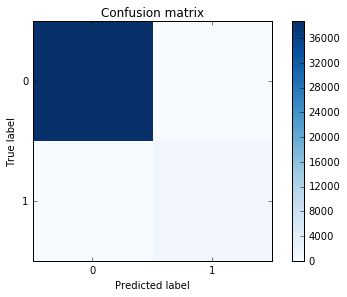

In [35]:
## confusion matrix plot

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

In [ ]:
## see the feature_importances

clf.feature_importances_

In [ ]:
test_x_scale[:100,-1]

## 3.2 Multi-class predict

In [ ]:
## load the arbitrage time txt data

ask_low_time_list=[]
bid_high_time_list=[]
no_arbi_time_list=[] 
time_list=[1,5,10,15,20]
import time 
t=time.time()
for ticker_ind in range(5):  
    ask_low_time_list.append([])
    bid_high_time_list.append([])
    no_arbi_time_list.append([])
    for time_ind in range(len(time_list)):
        ask_low_time_list[ticker_ind].append(
            np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_ask_low_time_'+str(time_list[time_ind])+'.txt',header=-1)))
        bid_high_time_list[ticker_ind].append(
            np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_bid_high_time_'+str(time_list[time_ind])+'.txt',header=-1)))
        no_arbi_time_list[ticker_ind].append(
            np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_no_arbi_time_'+str(time_list[time_ind])+'.txt',header=-1)))
        
print(time.time()-t)

In [ ]:
# Deal with the data
def build_y(ask_low,bid_high,no_arbi,option):
    if (option==1):
        return ask_low
    elif option==2:
        return bid_high
    elif option==3:
        return no_arbi
    elif option==4:
        return ask_low-bid_high
    else:
        print("option should be 1,2,3,4")
        
for ticker_ind in range(len(ticker_list)):
    response=build_y(ask_low_time_list[ticker_ind][1],bid_high_time_list[ticker_ind][1],\
                                 no_arbi_time_list[ticker_ind][1],option=4)
    np.savetxt(path_save+ticker_list[ticker_ind]+'_multiresponse.txt',response)

response_list=[]
for ticker_ind in range(len(ticker_list)):
    response_list.append((np.array(pd.read_csv(path_save+ticker_list[ticker_ind]+'_multiresponse.txt',header=-1))))

    ## print the shape of the response
## note it is the total response
print("The shape of the total response is:\n")

for ticker_ind in range(len(ticker_list)):
    print(response_list[ticker_ind].shape)
    
# need to get the response from 10 to 15:30
# the shape of the response and the feature array should be equal 
response_reduced_list=[]
for ticker_ind in range(len(ticker_list)):
    first_ind = np.where(time_index_list[ticker_ind]>=start_ind)[0][0]
    last_ind=np.where(time_index_list[ticker_ind]<=end_ind)[0][-1]
    response_reduced_list.append(response_list[ticker_ind][first_ind:last_ind+1])
    
print("The shape of the reduced response is:\n")

## print the shape of reduced response
## response reduced is used for testing and training the model
for ticker_ind in range(len(ticker_list)):
    print(response_reduced_list[ticker_ind].shape)
    # random split data

In [ ]:
# random split
#split the data to train and test data set
import random
from sklearn.cross_validation import train_test_split

ticker_ind=1
size=100000

# combine the feature and response array to random sample
total_array=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind]),axis=1)[:size,:]


print("total shape:",total_array.shape)

train_x, test_x, train_y, test_y =train_test_split(\
total_array[:,:134],total_array[:,134], test_size=0.1, random_state=42)

# the y data need to reshape to size (n,) not (n,1)
test_y=test_y.reshape(len(test_y),)
train_y=train_y.reshape(len(train_y),)

print("test shape:",test_y.shape)
print("train shape:",train_y.shape)

In [ ]:
#time series split
#%%--------------------------------------------------------------------------------------------

ticker_ind=1
size =100000
time_index=time_index_list[ticker_ind]
# combine the feature and response array to random sample
time_index_reduced=time_index[(time_index>=start_ind)&(time_index<=end_ind)]
total_array=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind],
                            time_index_reduced.reshape(len(time_index_reduced),1)),axis=1)[:size,:]

total_array=total_array[np.random.randint(len(total_array),size=len(total_array)),:]

train_num_index=int(len(total_array)*0.9)

print("total array shape:",total_array.shape)

#split the data to train and test data set
train_x=total_array[:train_num_index,:134]
test_x=total_array[train_num_index:,:134]
train_y=total_array[:train_num_index,134]
test_y=total_array[train_num_index:,134]


# the y data need to reshape to size (n,) not (n,1)
test_y=test_y.reshape(len(test_y),)
train_y=train_y.reshape(len(train_y),)
print("train_x shape:",train_x.shape)
print("test_x shape:",test_x.shape)
print("test_y shape:",test_y.shape)
print("train_y shape:",train_y.shape)

In [ ]:
# scale the data
# can use the processing.scale function to scale the data
from sklearn import preprocessing
# note that we need to transfer the data type to float
# remark: should use data_test=data_test.astype('float'),very important !!!!
# use scale for zero mean and one std
scaler = preprocessing.StandardScaler().fit(train_x)


train_x_scale=scaler.transform(train_x)
test_x_scale=scaler.transform(test_x)

print(np.mean(train_x_scale,0))
print(np.mean(test_x_scale,0))

### one vs one

In [ ]:
# only run for random forest method
# one vs one case
# random forest
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier


## sample weights
#sample_weights=[]
#ratio=len(train_y)/sum(train_y==1)/10
#for i in range(len(train_x)):
#    if train_y[i]==0:
#        sample_weights.append(1)
#    else: sample_weights.append(ratio)


# training

# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf =  OneVsOneClassifier(RandomForestClassifier(max_depth=20,n_estimators=100,random_state= 987612345))
clf.fit(train_x_scale,train_y)

print(time.time()-t)

predict_y_test=np.array(clf.predict(train_x_scale))

print("train accuracy is:",sum(predict_y_test==train_y)/len(train_y))

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test=np.array(clf.predict(test_x_scale))
print("test time is :",time.time()-t)

print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))

# # test the score for the train data
# from sklearn.metrics import (precision_score, recall_score,
#                              f1_score)
# print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
# precision= precision_score(predict_y_test,test_y)
# recall = recall_score(predict_y_test,test_y)
# f1=f1_score(predict_y_test,test_y)
# print("precision is: \t %s" % precision)
# print("recall is: \t %s" % recall)
# print("f1 score is: \t %s" %f1)


# #draw the crosstab chart
# %matplotlib inline
# ## draw chart for the cross table
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, [-1,0,1])
    plt.yticks(tick_marks, [-1,0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

%matplotlib inline
# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.savefig("one_vs_one.png")
plt.show()

In [ ]:
# only run for random forest method
# one vs one case
# adaboosting
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier


## sample weights
#sample_weights=[]
#ratio=len(train_y)/sum(train_y==1)/10
#for i in range(len(train_x)):
#    if train_y[i]==0:
#        sample_weights.append(1)
#    else: sample_weights.append(ratio)


# training

# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf =  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100,random_state= 987612345)
clf.fit(train_x_scale,train_y)

print(time.time()-t)

predict_y_test=np.array(clf.predict(train_x_scale))

print("train accuracy is:",sum(predict_y_test==train_y)/len(train_y))

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test=np.array(clf.predict(test_x_scale))
print("test time is :",time.time()-t)

print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))

# # test the score for the train data
# from sklearn.metrics import (precision_score, recall_score,
#                              f1_score)
# print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
# precision= precision_score(predict_y_test,test_y)
# recall = recall_score(predict_y_test,test_y)
# f1=f1_score(predict_y_test,test_y)
# print("precision is: \t %s" % precision)
# print("recall is: \t %s" % recall)
# print("f1 score is: \t %s" %f1)


# #draw the crosstab chart
# %matplotlib inline
# ## draw chart for the cross table
from sklearn.metrics import confusion_matrix
%matplotlib inline
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, [-1,0,1])
    plt.yticks(tick_marks, [-1,0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.savefig("one_vs_one.png")
plt.show()

In [ ]:
#----------------
# one vs one case
# svm
#-------------------
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier


## sample weights
#sample_weights=[]
#ratio=len(train_y)/sum(train_y==1)/10
#for i in range(len(train_x)):
#    if train_y[i]==0:
#        sample_weights.append(1)
#    else: sample_weights.append(ratio)


# training

# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf =  OneVsOneClassifier(svm.SVC(C=1.0,kernel='poly',degree=2,max_iter=5000,shrinking=True, tol=0.001, verbose=False)
)
clf.fit(train_x_scale,train_y)

print(time.time()-t)

predict_y_test=np.array(clf.predict(train_x_scale))

print("train accuracy is:",sum(predict_y_test==train_y)/len(train_y))

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test=np.array(clf.predict(test_x_scale))
print("test time is :",time.time()-t)

print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))

# # test the score for the train data
# from sklearn.metrics import (precision_score, recall_score,
#                              f1_score)
# print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
# precision= precision_score(predict_y_test,test_y)
# recall = recall_score(predict_y_test,test_y)
# f1=f1_score(predict_y_test,test_y)
# print("precision is: \t %s" % precision)
# print("recall is: \t %s" % recall)
# print("f1 score is: \t %s" %f1)


# #draw the crosstab chart
# %matplotlib inline
# ## draw chart for the cross table
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, [-1,0,1])
    plt.yticks(tick_marks, [-1,0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.savefig("one_vs_one.png")
plt.show()

### One vs rest

In [ ]:
# only run for random forest method
# one vs rest case
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier





# change the depth of the tree to 6, number of estimators=100

t=time.time()
clf =  OneVsRestClassifier(RandomForestClassifier(max_depth=20,n_estimators=100,random_state= 987612345))
clf.fit(train_x_scale,train_y)

print(time.time()-t)

predict_y_test=np.array(clf.predict(train_x_scale))

print("train accuracy is:",sum(predict_y_test==train_y)/len(train_y))

# define a function to prefict the result by threshold
# note: logistic model will return two probability
def predict_threshold(predict_proba, threshold):
    res=[]
    for i in range(len(predict_proba)):
        res.append(int(predict_proba[i][1]>threshold))
    return res

t=time.time()
predict_y_test=np.array(clf.predict(test_x_scale))
print("test time is :",time.time()-t)
print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))

# # test the score for the train data
# from sklearn.metrics import (precision_score, recall_score,
#                              f1_score)
# print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
# precision= precision_score(predict_y_test,test_y)
# recall = recall_score(predict_y_test,test_y)
# f1=f1_score(predict_y_test,test_y)
# print("precision is: \t %s" % precision)
# print("recall is: \t %s" % recall)
# print("f1 score is: \t %s" %f1)


# #draw the crosstab chart
# %matplotlib inline
# ## draw chart for the cross table
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, [-1,0,1])
    plt.yticks(tick_marks, [-1,0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(test_y, predict_y_test)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.savefig("one_vs_rest.png")
plt.show()

## 4.P&L calculation

In [ ]:
def get_index(index, value):
    i=0
    while index[i] <value:
        i=i+1
    return i

In [ ]:
## for AMZN
ticker_ind =1
train_ratio=0.9
time_index=data_mess[:,0]
data_order_reduced=data_order[(time_index>= start_ind) & (time_index<= end_ind)]
time_index_reduced=time_index[(time_index>= start_ind) & (time_index<= end_ind)]
total_array_old=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind],
                                time_index_reduced.reshape(len(time_index_reduced),1)),axis=1)
data_order=data_order_list[ticker_ind]
data_mess=data_mess_list[ticker_ind]

In [ ]:
test_y.shape

In [ ]:
data_order_test=data_order_reduced[int(size*train_ratio):size,:]
time_index_test=time_index_reduced[int(size*train_ratio):size]

test_y_unrandom=total_array_old[int(size*train_ratio):size,134]
print(data_order_test.shape)
print(time_index_test.shape)

In [ ]:
y_bid_high_choose.shape

In [ ]:
import matplotlib.pyplot as plt

plt.plot(time_index_test[:10000],data_order_test[:10000,0],"r-",label="Ask price")
plt.plot(time_index_test[:10000],data_order_test[:10000,2],"b-",label="Bid price")

x_ask_low_choose=time_index_test[test_y_unrandom==1]
y_ask_low_choose=data_order_test[test_y_unrandom==1,0]
x_bid_high_choose=time_index_test[test_y_unrandom==-1]
y_bid_high_choose=data_order_test[test_y_unrandom==-1,2]

plt.plot(x_ask_low_choose[:30],y_ask_low_choose[:30],"gv",markersize=8,label="Ask low")
plt.plot(x_bid_high_choose[:30],y_bid_high_choose[:30],"r^",markersize=8,label="Bid high")
plt.xlabel("Time(s)")
plt.ylabel("Price($10^{-4}$\$)")
plt.legend(bbox_to_anchor=[1.4, 1])
plt.title("Arbitrage opportunities for "+ticker_list[ticker_ind]+"(5s)")
plt.savefig("arbitrage_plot.png")
plt.show()

In [ ]:
time_index_test=total_array[:,135][int(size*train_ratio):size]
# find the arbitrage occuring index
arbi_index=list(np.where(predict_y_test!=0)[0])
# find the index that 5 seconds later
arbi_future_index=[]
for i in arbi_index:
    arbi_future_index.append(get_index(time_index_reduced,time_index_test[i]+5))

In [ ]:
arbi_future_index

In [ ]:
total_array_test=total_array[int(size*train_ratio):size,:]
future_price=[]
current_price=[]
pnl=[]
for i in range(len(arbi_index)):
    #ask low
    if predict_y_test[arbi_index[i]]==1 :
        future_price=data_order_reduced[arbi_future_index[i],0]
        current_price=total_array_test[arbi_index[i],2]
        pnl.append(current_price-future_price)
    # bid high
    else: 
        future_price=data_order_reduced[arbi_future_index[i],2]
        current_price=total_array_test[arbi_index[i],0]
        pnl.append(future_price-current_price)

In [ ]:
pnl=np.array(pnl)
predict_arbi=predict_y_test[predict_y_test!=0]
plt.plot(pnl[predict_arbi==1],"b.",label="Ask low PnL")
plt.plot(pnl[predict_arbi==-1],"r.",label="Bid High PnL")

plt.xlabel("Arbitrage Index")
plt.ylabel("Profit($10^{-4}$\$)")
plt.title("PnL for "+ticker_list[ticker_ind])
plt.legend()
plt.savefig(ticker_list[ticker_ind]+"_pnl.png")
plt.show()

In [ ]:
cum_pnl=np.cumsum(pnl)
plt.plot(cum_pnl,"b.",label="Cumulative P&L")
plt.xlabel("Arbitrage Index")
plt.ylabel("Profit($10^{-4}$\$)")
plt.title("Cumulative PnL for "+ticker_list[ticker_ind])
plt.legend()
plt.savefig(ticker_list[ticker_ind]+"_cum_pnl.png")
plt.show()

### loop for all stock to plot the pnl

In [ ]:
#time series split
#%%--------------------------------------------------------------------------------------------

size =100000
for ticker_ind in range(2,5):
    # combine the feature and response array to random sample
    data_order=data_order_list[ticker_ind]
    data_mess=data_mess_list[ticker_ind]
    time_index=data_mess[:,0]
    data_order_reduced=data_order[(time_index>= start_ind) & (time_index<= end_ind)]
    time_index_reduced=time_index[(time_index>= start_ind) & (time_index<= end_ind)]
    total_array_old=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind],
                                    time_index_reduced.reshape(len(time_index_reduced),1)),axis=1)

    total_array=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind],
                                time_index_reduced.reshape(len(time_index_reduced),1)),axis=1)[:size,:]
    total_array=total_array[np.random.randint(len(total_array),size=len(total_array)),:]

    train_num_index=int(len(total_array)*0.9)

    print("total array shape:",total_array.shape)

    #split the data to train and test data set
    train_x=total_array[:train_num_index,:134]
    test_x=total_array[train_num_index:,:134]
    train_y=total_array[:train_num_index,134]
    test_y=total_array[train_num_index:,134]


    # the y data need to reshape to size (n,) not (n,1)
    test_y=test_y.reshape(len(test_y),)
    train_y=train_y.reshape(len(train_y),)
    print("train_x shape:",train_x.shape)
    print("test_x shape:",test_x.shape)
    print("test_y shape:",test_y.shape)
    print("train_y shape:",train_y.shape)


    # scale the data
    # can use the processing.scale function to scale the data
    from sklearn import preprocessing
    # note that we need to transfer the data type to float
    # remark: should use data_test=data_test.astype('float'),very important !!!!
    # use scale for zero mean and one std
    scaler = preprocessing.StandardScaler().fit(train_x)


    train_x_scale=scaler.transform(train_x)
    test_x_scale=scaler.transform(test_x)

    print(np.mean(train_x_scale,0))
    print(np.mean(test_x_scale,0))

    from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
    # change the depth of the tree to 6, number of estimators=100

    t=time.time()
    clf =  OneVsRestClassifier(RandomForestClassifier(max_depth=20,n_estimators=100,random_state= 987612345))
    clf.fit(train_x_scale,train_y)

    print(time.time()-t)

    predict_y_test=np.array(clf.predict(train_x_scale))

    print("train accuracy is:",sum(predict_y_test==train_y)/len(train_y))

    # define a function to prefict the result by threshold
    # note: logistic model will return two probability
    def predict_threshold(predict_proba, threshold):
        res=[]
        for i in range(len(predict_proba)):
            res.append(int(predict_proba[i][1]>threshold))
        return res

    t=time.time()
    predict_y_test=np.array(clf.predict(test_x_scale))
    print("test time is :",time.time()-t)
    print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))

    # # test the score for the train data
    # from sklearn.metrics import (precision_score, recall_score,
    #                              f1_score)
    # print("test accuracy is:",sum(predict_y_test==test_y)/len(test_y))
    # precision= precision_score(predict_y_test,test_y)
    # recall = recall_score(predict_y_test,test_y)
    # f1=f1_score(predict_y_test,test_y)
    # print("precision is: \t %s" % precision)
    # print("recall is: \t %s" % recall)
    # print("f1 score is: \t %s" %f1)


    # #draw the crosstab chart
    # %matplotlib inline
    # ## draw chart for the cross table
    from sklearn.metrics import confusion_matrix

    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(3)
        plt.xticks(tick_marks, [-1,0,1])
        plt.yticks(tick_marks, [-1,0,1])
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


    # Compute confusion matrix
    cm = confusion_matrix(test_y, predict_y_test)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)
    plt.savefig("one_vs_rest.png")
    plt.show()
    
    def get_index(index, value):
        i=0
        while index[i] <value:
            i=i+1
        return i


    train_ratio=0.9
    time_index=data_mess[:,0]
    data_order_reduced=data_order[(time_index>= start_ind) & (time_index<= end_ind)]
    time_index_reduced=time_index[(time_index>= start_ind) & (time_index<= end_ind)]
    total_array_old=np.concatenate((feature_array_list[ticker_ind],response_reduced_list[ticker_ind],
                                    time_index_reduced.reshape(len(time_index_reduced),1)),axis=1)
    data_order=data_order_list[ticker_ind]
    data_mess=data_mess_list[ticker_ind]

    time_index_test=total_array[:,135][int(size*train_ratio):size]
    # find the arbitrage occuring index
    arbi_index=list(np.where(predict_y_test!=0)[0])
    # find the index that 5 seconds later
    arbi_future_index=[]
    for i in arbi_index:
        arbi_future_index.append(get_index(time_index_reduced,time_index_test[i]+5))

    total_array_test=total_array[int(size*train_ratio):size,:]
    future_price=[]
    current_price=[]
    pnl=[]
    for i in range(len(arbi_index)):
        #ask low
        if predict_y_test[arbi_index[i]]==1 :
            future_price=data_order_reduced[arbi_future_index[i],0]
            current_price=total_array_test[arbi_index[i],2]
            pnl.append(current_price-future_price)
        # bid high
        else: 
            future_price=data_order_reduced[arbi_future_index[i],2]
            current_price=total_array_test[arbi_index[i],0]
            pnl.append(future_price-current_price)

    pnl=np.array(pnl)
    predict_arbi=predict_y_test[predict_y_test!=0]
    plt.plot(pnl[predict_arbi==1],"b.",label="Ask low PnL")
    plt.plot(pnl[predict_arbi==-1],"r.",label="Bid High PnL")

    plt.xlabel("Arbitrage Index")
    plt.ylabel("Profit($10^{-4}$\$)")
    plt.title("PnL for "+ticker_list[ticker_ind])
    plt.legend()
    plt.savefig(ticker_list[ticker_ind]+"_pnl.png")
    plt.show()

    cum_pnl=np.cumsum(pnl)
    plt.plot(cum_pnl,"b.",label="Cumulative P&L")
    plt.xlabel("Arbitrage Index")
    plt.ylabel("Profit($10^{-4}$\$)")
    plt.title("Cumulative PnL for "+ticker_list[ticker_ind])
    plt.legend()
    plt.savefig(ticker_list[ticker_ind]+"_cum_pnl.png")
    plt.show()

# Plot the order book type

use the data_mess data set to plot the chart of the order book type

## 1.Plot the order book types

In [ ]:
import time
order_type_list=[]
t=time.time()
for ticker_ind in range(5):
    order_type=[]
    for i in [1,2,3,4,5]:
        order_type.append(sum(data_mess_list[ticker_ind][:,1]==i))
    order_type_list.append(order_type)
print(time.time()-t)

In [ ]:
print(order_type_list[4])

In [ ]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
# n_groups = 5

# means_men = (20, 35, 30, 35, 27)
# std_men = (2, 3, 4, 1, 2)

# means_women = (25, 32, 34, 20, 25)
# std_women = (3, 5, 2, 3, 3)

# fig, ax = plt.subplots()

# index = np.arange(n_groups)
# bar_width = 0.35

# opacity = 0.4
# error_config = {'ecolor': '0.3'}

# rects1 = plt.bar(index, means_men, bar_width,
#                  alpha=opacity,
#                  color='b',
#                  yerr=std_men,
#                  error_kw=error_config,
#                  label='Men')

# rects2 = plt.bar(index + bar_width, means_women, bar_width,
#                  alpha=opacity,
#                  color='r',
#                  yerr=std_women,
#                  error_kw=error_config,
#                  label='Women')

# plt.xlabel('Group')
# plt.ylabel('Scores')
# plt.title('Scores by group and gender')
# plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
# plt.legend()

# plt.tight_layout()
# plt.show()

order_type_array=np.array(order_type_list)


n_groups=7.5
index = np.arange(n_groups,step=1.5)    # the x locations for the groups
ticker_list=['AAPL', 'AMZN', 'GOOG', 'INTC','MSFT']
color_list=['red','yellow','green','blue','darkmagenta']
type_list=['1:Order_book','2:Cancel_part','3:Delete_all','4:Execution_visible','5:Execution_hidden']

fig, ax = plt.subplots()

bar_width = 0.25

opacity = 0.6
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, order_type_array[:,0], bar_width,
                 alpha=opacity,
                 color=color_list[0],
                 error_kw=error_config,
                 label=type_list[0])

rects2 = plt.bar(index + 1*bar_width, order_type_array[:,1], bar_width,
                 alpha=opacity,
                 color=color_list[1],
                 error_kw=error_config,
                 label=type_list[1])


rects3 = plt.bar(index + 2*bar_width, order_type_array[:,2], bar_width,
                 alpha=opacity,
                 color=color_list[2],
                 error_kw=error_config,
                 label=type_list[2])

rects4 = plt.bar(index + 3*bar_width, order_type_array[:,3], bar_width,
                 alpha=opacity,
                 color=color_list[3],
                 error_kw=error_config,
                 label=type_list[3])

rects5 = plt.bar(index + 4*bar_width, order_type_array[:,4], bar_width,
                 alpha=opacity,
                 color=color_list[4],
                 error_kw=error_config,
                 label=type_list[4])


plt.xlabel('Stock Ticker')
plt.ylabel('Numbers')
plt.title('Order Book Types')
plt.xticks(index + bar_width*2.5, ticker_list)
plt.yticks(np.arange(0, 700000,50000))
plt.legend()
plt.tight_layout()
plt.show()

## 2.Plot the arbitrage situation (bid high, ask low and no arbitrage)

Take the first stock which is AAPL as example

In [ ]:
data_order_reduced=data_order_list[0][(time_index_list[0]>= start_ind) & (time_index_list[0]<= end_ind)]
data_mess_reduced=data_mess_list[0][(time_index_list[0]>= start_ind) & (time_index_list[0]<= end_ind)]
time_index_reduced=time_index_list[0][(time_index_list[0]>= start_ind) & (time_index_list[0]<= end_ind)]

In [ ]:
first_ind=np.where(ask_low_time_list[0][1]==1)[0][0]
last_ind=np.where(time_index_reduced>time_index_reduced[first_ind]+5)[0][0]
print("first_ind:",first_ind)
print("last_ind:",last_ind)

In [ ]:
%matplotlib qt
time_index=time_index_reduced[first_ind:last_ind+1]
ask_price=data_order_reduced[first_ind:last_ind+1,0]
bid_price=data_order_reduced[first_ind:last_ind+1,2]
print(ask_pirce[1])
print(bid_price[1])
plt.plot(time_index,ask_price,'r.-',label="Ask Price")
plt.plot(time_index,bid_price,'b.-',label="Bid Price")

plt.xticks=time_index
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Ask Low Arbitrage Example")
plt.legend(loc='upper center')
plt.show()

In [ ]:
np.where(bid_high_time_list[0][1]==1)

In [ ]:
## the bid high case

first_ind=np.where(bid_high_time_list[0][1]==1)[0][20]
last_ind=np.where(time_index_list[0]>time_index_list[0][first_ind]+5)[0][0]
print("first_ind:",first_ind)
print("last_ind:",last_ind)

%matplotlib qt
time_index=time_index_list[0][first_ind:last_ind+1]
ask_price=data_order_list[0][first_ind:last_ind+1,0]
bid_price=data_order_list[0][first_ind:last_ind+1,2]
print(ask_pirce[1])
print(bid_price[1])
plt.plot(time_index,ask_price,'r.-',label="Ask Price")
plt.plot(time_index,bid_price,'b.-',label="Bid Price")

plt.xticks=time_index
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bid High Arbitrage Example")
plt.legend(loc='upper center')
plt.show()

In [ ]:
## the no arbitrage case
first_ind=np.where(no_arbi_time_list[0][1]==1)[0][20]
last_ind=np.where(time_index_list[0]>time_index_list[0][first_ind]+5)[0][0]
print("first_ind:",first_ind)
print("last_ind:",last_ind)

%matplotlib qt
time_index=time_index_list[0][first_ind:last_ind+1]
ask_price=data_order_list[0][first_ind:last_ind+1,0]
bid_price=data_order_list[0][first_ind:last_ind+1,2]
print(ask_pirce[1])
print(bid_price[1])
plt.plot(time_index,ask_price,'r.-',label="Ask Price")
plt.plot(time_index,bid_price,'b.-',label="Bid Price")

plt.xticks=time_index
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("No Arbitrage Example")
plt.legend(loc='upper center')
plt.show()

## 3.plot the statistical properties

### 1) cumulative distribution function for arrival time

In [ ]:
ticker_ind=2
data=data_mess_list[ticker_ind]
# we use the market order
data_order=data[(data[:,1]==4) | (data[:,1]==5)]

arrival_time=data_order[1:,0]-data_order[0:-1,0]
#delete the zero intra arrival time
arrival_time=arrival_time[arrival_time>0]

In [ ]:
mu_log=np.mean(np.log(arrival_time))
std_log=np.std(np.log(arrival_time))
data_log=np.random.lognormal(mu_log,std_log,arrival_time.shape)

mu_exp=np.mean(arrival_time)
data_exp=np.random.exponential(mu_exp,arrival_time.shape)

data_weibull=np.random.weibull(0.38,arrival_time.shape)
beta=np.var(arrival_time)/np.mean(arrival_time)
alpha=np.mean(arrival_time)/beta
data_gamma=np.random.gamma(alpha,beta,arrival_time.shape)

In [ ]:
%matplotlib inline
import statsmodels.api as sm
from scipy.stats.kde import gaussian_kde

from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm
ecdf = sm.distributions.ECDF(arrival_time,)
plt.xlim([0,10])
plt.plot(ecdf.x, ecdf.y,"b",label="Original data")

ecdf = sm.distributions.ECDF(data_log)
plt.xlim([0,10])
plt.plot(ecdf.x, ecdf.y,"g",label="Lognormal Distribution")

ecdf = sm.distributions.ECDF(data_exp)
plt.xlim([0,10])
plt.plot(ecdf.x, ecdf.y,"y",label="Exponential distribution")

ecdf = sm.distributions.ECDF(data_weibull)
plt.xlim([0,10])
plt.plot(ecdf.x, ecdf.y,"r",label="Weibull distribution")


ecdf = sm.distributions.ECDF(data_t)
plt.xlim([0,10])
plt.plot(ecdf.x, ecdf.y,"purple",label="Gamma distribution")


plt.xlabel("Intra-arrival time")
plt.ylabel("Probability")
plt.legend(loc="lower right")
plt.title("Cumulative distribution function of order arrival time")
plt.show()

### 1) loop for all stocks

In [ ]:
f, axarr = plt.subplots(2, 2,figsize=(13, 13))
for tickerb_ind in range(1,5):
    data=data_mess_list[ticker_ind]
    # we use the market order
    data_order=data[(data[:,1]==4) | (data[:,1]==5)]

    arrival_time=data_order[1:,0]-data_order[0:-1,0]
    #delete the zero intra arrival time
    arrival_time=arrival_time[arrival_time>0]
    mu_log=np.mean(np.log(arrival_time))
    std_log=np.std(np.log(arrival_time))
    data_log=np.random.lognormal(mu_log,std_log,arrival_time.shape)

    mu_exp=np.mean(arrival_time)
    data_exp=np.random.exponential(mu_exp,arrival_time.shape)

    data_weibull=np.random.weibull(0.38,arrival_time.shape)
    beta=np.var(arrival_time)/np.mean(arrival_time)
    alpha=np.mean(arrival_time)/beta
    data_gamma=np.random.gamma(alpha,beta,arrival_time.shape)
    ecdf = sm.distributions.ECDF(arrival_time,)
   
  
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlim([0,10])
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].plot(ecdf.x, ecdf.y,"b",label="Original data")

    ecdf = sm.distributions.ECDF(data_log)
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlim([0,10])
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].plot(ecdf.x, ecdf.y,"g",label="Lognormal Distribution")

    ecdf = sm.distributions.ECDF(data_exp)
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlim([0,10])
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].plot(ecdf.x, ecdf.y,"y",label="Exponential distribution")

    ecdf = sm.distributions.ECDF(data_weibull)
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlim([0,10])
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].plot(ecdf.x, ecdf.y,"r",label="Weibull distribution")


    ecdf = sm.distributions.ECDF(data_t)
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlim([0,10])
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].plot(ecdf.x, ecdf.y,"purple",label="Gamma distribution")
    
    
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_xlabel("Intra-arrival time")
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_ylabel("Probability")
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].legend(loc="lower right")
    axarr[int((ticker_ind-1)/2),(ticker_ind+1)%2].set_title("Cumulative distribution function of \n order arrival time  for stock "+ticker_list[ticker_ind])

plt.savefig('arrival_time.png', bbox_inches='tight')
plt.show()

### 2) volume 

In [ ]:
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm  
import seaborn as sns
ticker_ind=0
x=np.linspace(0,50,1000)
y=x**(-2.1)/500
plt.plot(np.log(x)+3,y,"g--",label="Power law with $\propto x^{-2.1}$")
y_exp=np.exp(-x)
plt.plot(np.log(x)+2,y_exp,"r--",label="Exponential distribution")
data=data_mess_list[ticker_ind]

data_market=data[(data[:,1]==4) | (data[:,1]==5)]
data_order=data[data[:,1]==1]
mean_market=np.mean(data_market[:,3])
mean_order=np.mean(data_order[:,3])

vol_market_scale=data_market[:,3]/mean_market
vol_order_scale=data_order[:,3]/mean_order

sns.kdeplot(np.log(vol_market_scale), shade=True,label=ticker_list[ticker_ind]+" Data")

plt.xlim([0,5])
plt.ylim([0,1])
plt.legend()
plt.xlabel("Log scale of normalized volume of market orders")
plt.ylabel("Probability functions")
plt.title("Emprical probability density function of \n nomalized volume of "+ticker_list[ticker_ind])
plt.savefig("volume_AAPL.png")
plt.show()

ticker_ind=1
x=np.linspace(0,50,1000)
y=x**(-2.1)/500
plt.plot(np.log(x)+3,y,"g--",label="Power law with $\propto x^{-2.1}$")
y_exp=np.exp(-x)
plt.plot(np.log(x)+2,y_exp,"r--",label="Exponential distribution")
data=data_mess_list[ticker_ind]

data_market=data[(data[:,1]==4) | (data[:,1]==5)]
data_order=data[data[:,1]==1]
mean_market=np.mean(data_market[:,3])
mean_order=np.mean(data_order[:,3])

vol_market_scale=data_market[:,3]/mean_market
vol_order_scale=data_order[:,3]/mean_order

sns.kdeplot(np.log(vol_market_scale), shade=True,label=ticker_list[ticker_ind]+" Data")

plt.xlim([0,5])
plt.ylim([0,1])
plt.legend()
plt.xlabel("Log scale of normalized volume of market orders")
plt.ylabel("Probability functions")
plt.title("Emprical probability density function of \n nomalized volume of "+ticker_list[ticker_ind])
plt.savefig("volume_AMZN.png")
plt.show()

ticker_ind=3
x=np.linspace(0,50,1000)
y=x**(-2.1)/500
plt.plot(np.log(x)+3,y,"g--",label="Power law with $\propto x^{-2.1}$")
y_exp=np.exp(-x)
plt.plot(np.log(x)+2,y_exp,"r--",label="Exponential distribution")
data=data_mess_list[ticker_ind]

data_market=data[(data[:,1]==4) | (data[:,1]==5)]
data_order=data[data[:,1]==1]
mean_market=np.mean(data_market[:,3])
mean_order=np.mean(data_order[:,3])

vol_market_scale=data_market[:,3]/mean_market
vol_order_scale=data_order[:,3]/mean_order

sns.kdeplot(np.log(vol_market_scale)+1.2, shade=True,label=ticker_list[ticker_ind]+" Data")

plt.xlim([0,5])
plt.ylim([0,1])
plt.legend()
plt.xlabel("Log scale of normalized volume of market orders")
plt.ylabel("Probability functions")
plt.title("Emprical probability density function of \n nomalized volume of "+ticker_list[ticker_ind])
plt.savefig("volume_INTC.png")
plt.show()

ticker_ind=4
x=np.linspace(0,50,1000)
y=x**(-2.1)/500
plt.plot(np.log(x)+3,y,"g--",label="Power law with $\propto x^{-2.1}$")
y_exp=np.exp(-x)
plt.plot(np.log(x)+2,y_exp,"r--",label="Exponential distribution")
data=data_mess_list[ticker_ind]

data_market=data[(data[:,1]==4) | (data[:,1]==5)]
data_order=data[data[:,1]==1]
mean_market=np.mean(data_market[:,3])
mean_order=np.mean(data_order[:,3])

vol_market_scale=data_market[:,3]/mean_market
vol_order_scale=data_order[:,3]/mean_order

sns.kdeplot(np.log(vol_market_scale)+1.2, shade=True,label=ticker_list[ticker_ind]+" Data")

plt.xlim([0,5])
plt.ylim()
plt.legend()
plt.xlabel("Log scale of normalized volume of market orders")
plt.ylabel("Probability functions")
plt.title("Emprical probability density function of \n nomalized volume of "+ticker_list[ticker_ind])
plt.savefig("volume_MSFT.png")
plt.show()

### 3) Intraday seasonality

observe the volume during the whole day under 5 minutes time bins. show the result of seasonality

In [ ]:
ticker_ind=0
data_mess=data_mess_list[ticker_ind]
data_mess_limit=data_mess[data_mess[:,1]==1,:]

In [ ]:
# calute the volume of limit order book in each time interval

time_interval=np.linspace(data_mess_limit[:,0].min(),data_mess_limit[:,0].max(),78)
vol=0
vol_time=[]
j=1

for i in range(len(data_mess_limit)):
    if  data_mess_limit[i,0]<=time_interval[j]:
        vol=vol+data_mess_limit[i,3]
    else: 
        j=j+1
        vol_time.append(vol)
        vol=data_mess_limit[i,3]

In [ ]:
# plot the quadratic fit and vol_time
x=range(76)
plt.plot(x,vol_time,label=ticker_list[ticker_ind])
qua_fit=np.poly1d(np.polyfit(x, vol_time, 2))(x)
plt.plot(x,qua_fit,label=ticker_list[ticker_ind]+" quadratic fit")
plt.legend(loc="lower right")
xticks=np.arange(34200,57600,2400)
plt.xticks(x[::8],xticks)
plt.show()

### loop for all stocks

In [ ]:
# for limit order 


%matplotlib inline
import seaborn as sns

for ticker_ind in range(1,5):

    data_mess=data_mess_list[ticker_ind]
    data_mess_limit=data_mess[data_mess[:,1]==1,:]
    # calute the volume of limit order book in each time interval

    time_interval=np.linspace(data_mess_limit[:,0].min(),data_mess_limit[:,0].max(),78)
    vol=0
    vol_time=[]
    j=1

    for i in range(len(data_mess_limit)):
        if  data_mess_limit[i,0]<=time_interval[j]:
            vol=vol+data_mess_limit[i,3]
        else: 
            j=j+1
            vol_time.append(vol)
            vol=data_mess_limit[i,3]
    # plot the quadratic fit and vol_time
    x=range(76)
    plt.plot(x,vol_time,"+-",label=ticker_list[ticker_ind])
    qua_fit=np.poly1d(np.polyfit(x, vol_time, 2))(x)
    plt.plot(x,qua_fit,"--",label=ticker_list[ticker_ind]+" quadratic fit")
    plt.legend(loc="upper center")
    xticks=np.arange(34200,57600,2400)
    plt.xticks(x[::8],xticks)
    plt.title("Number of limit orders in a 5-minute interval for "+ticker_list[ticker_ind])
    plt.xlabel("Time of day(seconds)")
    plt.ylabel("Number of limit orders submitted in $\Delta_t=5$ minutes")
    plt.savefig(ticker_list[ticker_ind]+"_limit_vol_time.png",bbox_inches='tight')

    plt.show()

In [ ]:
# market order

%matplotlib inline
import seaborn as sns

for ticker_ind in range(1,5):

    data_mess=data_mess_list[ticker_ind]
    data_mess_market=data_mess[(data_mess[:,1]==4) | (data_mess[:,1]==5),:]
    # calute the volume of limit order book in each time interval

    time_interval=np.linspace(data_mess_market[:,0].min(),data_mess_market[:,0].max(),78)
    vol=0
    vol_time=[]
    j=1

    for i in range(len(data_mess_market)):
        if  data_mess_market[i,0]<=time_interval[j]:
            vol=vol+data_mess_market[i,3]
        else: 
            j=j+1
            vol_time.append(vol)
            vol=data_mess_market[i,3]
    # plot the quadratic fit and vol_time
    x=range(76)
    plt.plot(x,vol_time,"+-",label=ticker_list[ticker_ind])
    qua_fit=np.poly1d(np.polyfit(x, vol_time, 2))(x)
    plt.plot(x,qua_fit,"--",label=ticker_list[ticker_ind]+" quadratic fit")
    plt.legend(loc="upper center")
    xticks=np.arange(34200,57600,2400)
    plt.xticks(x[::8],xticks)
    plt.title("Number of market orders in a 5-minute interval for "+ticker_list[ticker_ind])
    plt.xlabel("Time of day(seconds)")
    plt.ylabel("Number of market orders submitted in $\Delta_t=5$ minutes")
    plt.savefig(ticker_list[ticker_ind]+"_market_vol_time.png",bbox_inches='tight')
    plt.show()

### 4) average shape of the order books
find the total volume for all each price level and see the volume trend based on the price levels


In [ ]:
### 4) average shape of the order books
%matplotlib inline
import seaborn as sns

ticker_ind=1
data_mess=data_mess_list[ticker_ind]
data_order=data_order_list[ticker_ind]
data_order_limit_ask_vol=data_order[data_mess[:,1]==1,1:40:4]
data_order_limit_bid_vol=data_order[data_mess[:,1]==1,3:40:4]

vol_ask=np.sum(data_order_limit_ask_vol,axis=0)/np.mean(np.sum(data_order_limit_ask_vol,axis=0))
vol_bid=np.sum(data_order_limit_bid_vol,axis=0)/np.mean(np.sum(data_order_limit_bid_vol,axis=0))
plt.plot(list(range(-10,0)),vol_bid)
plt.plot(list(range(1,11)),vol_ask)

### loop the stocks

In [ ]:
marker_list=["s","D","^","8"]
color_list=["g","b","r","y"]
for ticker_ind in range(1,5):
    data_mess=data_mess_list[ticker_ind]
    data_order=data_order_list[ticker_ind]
    data_order_limit_ask_vol=data_order[:,1:40:4]
    data_order_limit_bid_vol=data_order[:,3:40:4]

    vol_ask=np.sum(data_order_limit_ask_vol,axis=0)/np.mean(np.sum(data_order_limit_ask_vol,axis=0))
    vol_bid=np.sum(data_order_limit_bid_vol,axis=0)/np.mean(np.sum(data_order_limit_bid_vol,axis=0))
    plt.plot(list(range(-10,0)),vol_bid,
             "--",marker=marker_list[ticker_ind-1],color=color_list[ticker_ind-1],label=
            ticker_list[ticker_ind])
    plt.plot(list(range(1,11)),vol_ask,"--",marker=marker_list[ticker_ind-1],color=color_list[ticker_ind-1])
plt.ylim([0.6,1.6])
plt.legend(loc="upper right")
plt.title("Average quantity offered in the market order book")
plt.xlabel("Price level of limit orders (negative axis : bids ; positive axis : asks)")
plt.ylabel("Average numbers of shares(Normalized by mean)")
plt.savefig("level_quantity.png",bbox_inches='tight')    
plt.show()

### 5) placement of orders


In [ ]:
ticker_ind=2
data_mess=data_mess_list[ticker_ind]
data_order=data_order_list[ticker_ind]

data_mess_limit=data_mess[data_mess[:,1]==1,:]
data_order_limit=data_order[data_mess[:,1]==1,:]

In [ ]:
spread_list=[]
for i in range(1,len(data_mess_limit)):
    if data_mess_limit[i,5]==-1:
        spread=data_mess_limit[i,4]-data_order_limit[i-1,0]
    else:
        spread=data_order_limit[i-1,2]-data_mess_limit[i,4]
    spread_list.append(spread)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
sns.kdeplot(np.array(spread_list), shade=True,label=ticker_list[ticker_ind]+" Data")
mu = 0
variance = np.var(spread_list)
sigma = math.sqrt(variance)
x = np.linspace(min(spread_list), max(spread_list), 100)
plt.plot(x,mlab.normpdf(x, mu, sigma),"r--",label="Gaussian")
plt.xlim([-10000,10000])

### loop for all stocks

In [ ]:
for ticker_ind in range(1,5):
    data_mess=data_mess_list[ticker_ind]
    data_order=data_order_list[ticker_ind]

    data_mess_limit=data_mess[data_mess[:,1]==1,:]
    data_order_limit=data_order[data_mess[:,1]==1,:]

    spread_list=[]
    for i in range(1,len(data_mess_limit)):
        if data_mess_limit[i,5]==-1:
            spread=data_mess_limit[i,4]-data_order_limit[i-1,0]
        else:
            spread=data_order_limit[i-1,2]-data_mess_limit[i,4]
        spread_list.append(spread)


    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.mlab as mlab
    import math
    sns.kdeplot(np.array(spread_list), shade=True,label=ticker_list[ticker_ind]+" Data")
    mu = 0
    variance = np.var(spread_list)
    sigma = math.sqrt(variance)
    x = np.linspace(min(spread_list), max(spread_list), 100)
    plt.plot(x,mlab.normpdf(x, mu, sigma),"r--",label="Gaussian")
    plt.xlim([min(spread_list)*0.8,max(spread_list)*0.8])
    plt.legend(loc="upper right")
    plt.title("Placement of limit orders using the\n same best quote reference for "+ticker_list[ticker_ind])
    plt.xlabel("Price diference")
    plt.ylabel("Probability density function")
    plt.savefig(ticker_list[ticker_ind]+"_placement.png",bbox_inches='tight')    
    plt.show()